In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [189]:
df = pd.read_excel('combined_data_20240926.xlsx')

In [172]:
# 假设 df_combined_sorted 已经包含 scraped_time 和 submissionTime 列，并且它们都是字符串格式

# 将 scraped_time 和 submissionTime 列转换为 datetime 格式
df['scraped_time'] = pd.to_datetime(df['scraped_time'], errors='coerce')
df['submissionTime'] = pd.to_datetime(df['submissionTime'], errors='coerce')

# 计算天数差
df['days_difference'] = (df['scraped_time'] - df['submissionTime']).dt.days

# 将 price 中的 0 替换为 NaN
df['price'].replace(0, pd.NA, inplace=True)

# 基于 productLabel 分组，然后对每个组的 price 列进行向前填充
df['price'] = df.groupby('productLabel')['price'].fillna(method='ffill')

df['totalReviews'].replace(np.nan, 0, inplace=True)
# 确保 price 和 totalReviews 列为数值类型，coerce 会将无效数据转换为 NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['totalReviews'] = pd.to_numeric(df['totalReviews'], errors='coerce')

# 检查并处理 storeSkuNumber 和 parentId 列
# 去掉小数点，先将其转换为整数再转换为字符串
df['storeSkuNumber'] = df['storeSkuNumber'].apply(lambda x: str(int(x)) if pd.notnull(x) else None)
df['parentId'] = df['parentId'].apply(lambda x: str(int(x)) if pd.notnull(x) else None)

C:\Users\cs\AppData\Local\Temp\ipykernel_29248\1850498729.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].replace(0, pd.NA, inplace=True)
C:\Users\cs\AppData\Local\Temp\ipykernel_29248\1850498729.py:14: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['price'] = df.groupby('productLabel')['price'].fillna(method='ffill')
C:\User

In [173]:
latest_date = df['scraped_time'].max()
# 过滤出最新日期的数据
latest_data = df[df['scraped_time'] == latest_date]

In [174]:
# 计算 price * totalReviews
latest_data['price_totalReviews'] = latest_data['price'] * latest_data['totalReviews']

C:\Users\cs\AppData\Local\Temp\ipykernel_29248\673700937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_data['price_totalReviews'] = latest_data['price'] * latest_data['totalReviews']


In [175]:
# 选择 price * totalReviews 值最多的五个 productLabel
top_products = latest_data.nlargest(5, 'price_totalReviews')[df.columns]

In [176]:
top_5_data = df[df['productLabel'].isin(top_products['productLabel'])].drop(columns=['Unnamed: 0', 'id', 'Order', 'isSponsored'])

In [178]:
# 按周和产品标题分组，并计算每周 Review_Number 的最小值
weekly_reviews = top_5_data.groupby(['productLabel', top_5_data['scraped_time'].dt.to_period('W').apply(lambda r: r.start_time)])['totalReviews'].min().reset_index()

# 计算每周的平均价格
weekly_price = top_5_data.groupby(['productLabel', top_5_data['scraped_time'].dt.to_period('W').apply(lambda r: r.start_time)])['price'].min().reset_index()

In [180]:
# 合并 Review_Number 和价格信息
weekly_reviews = pd.merge(weekly_reviews, weekly_price, on=['productLabel', 'scraped_time'], how='left')

In [182]:
# 设置向下移动的周数
x = 2

# 将未来 x 周的 totalReviews 向下移动
weekly_reviews['Future_Review_Num'] = weekly_reviews.groupby('productLabel')['totalReviews'].shift(-x)

In [184]:
# 计算 review_increment: 用当前 Future_Review_Num 减去前一周的值
weekly_reviews['review_increment'] = weekly_reviews.groupby('productLabel')['Future_Review_Num'].diff()

In [186]:
weekly_reviews['Sales_increment'] = (weekly_reviews['review_increment'] * weekly_reviews['price'] * 100).clip(lower=0)

In [190]:
# 去掉最后两周的 NaN 值
weekly_reviews = weekly_reviews[~weekly_reviews['Sales_increment'].isna()]

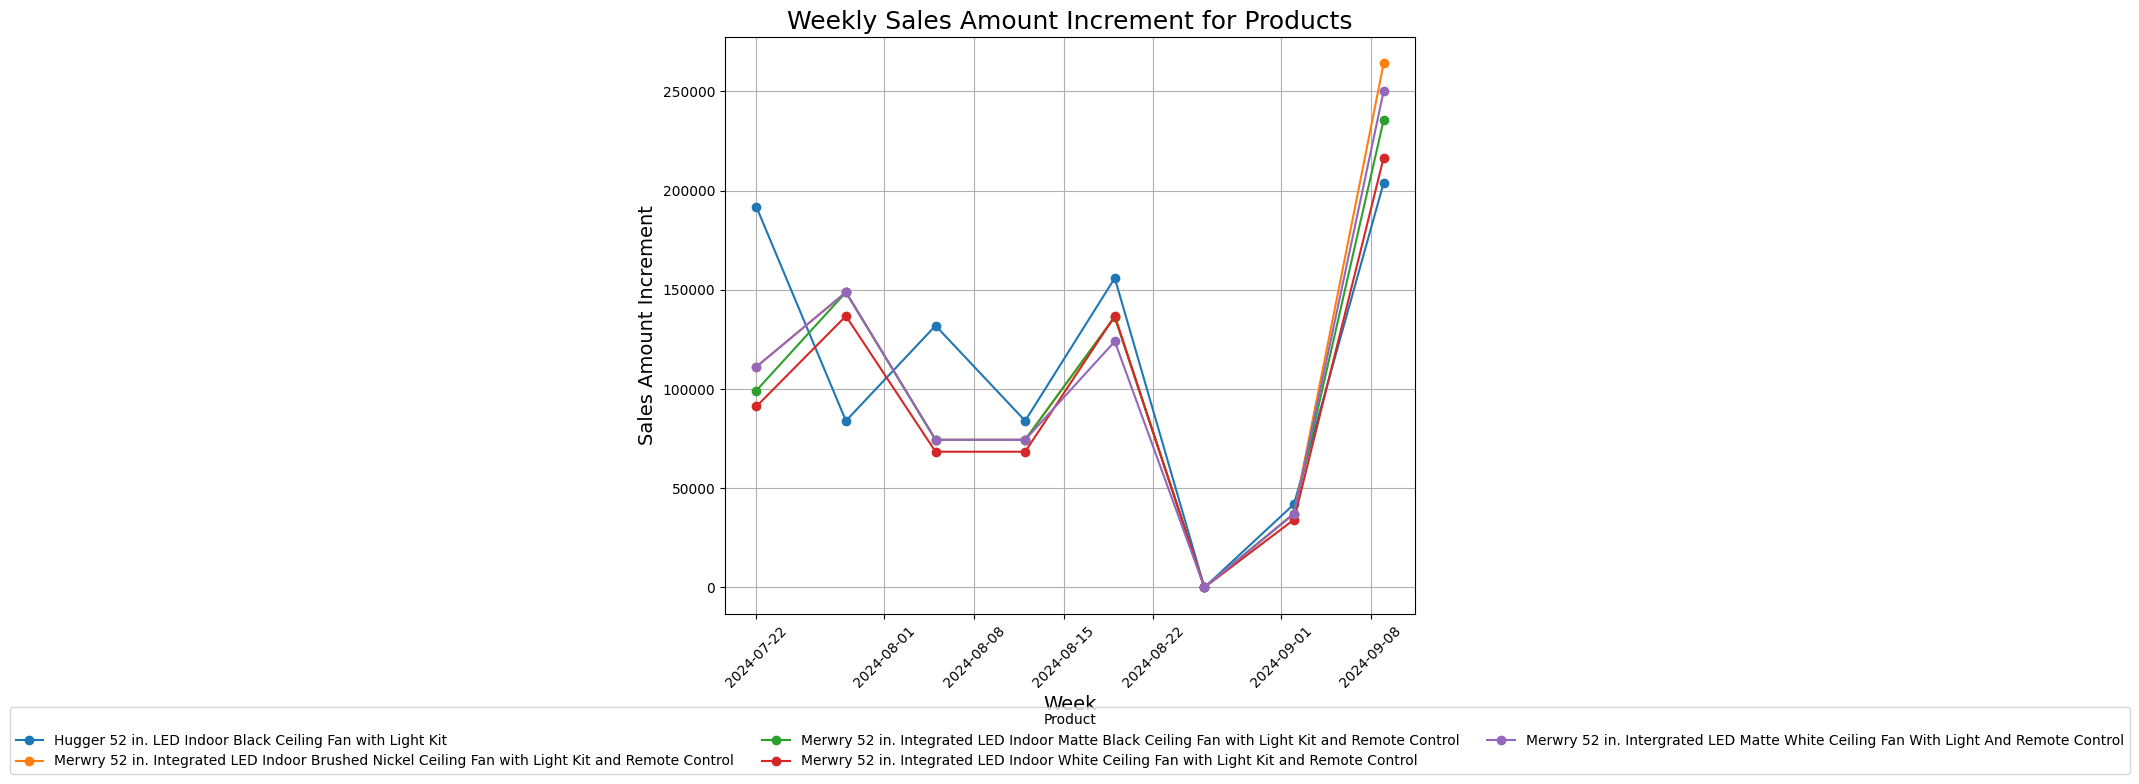

In [188]:
# 设置画布，增大尺寸
plt.figure(figsize=(16, 8))

# 绘制每个产品的 Sales_amt 增量折线图
for product, group in weekly_reviews.groupby('productLabel'):
    plt.plot(group['scraped_time'], group['Sales_increment'], marker='o', linestyle='-', label=product)

# 设置标题和标签
plt.title('Weekly Sales Amount Increment for Products', fontsize=18)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Sales Amount Increment', fontsize=14)

# 旋转日期标签以便更好地显示
plt.xticks(rotation=45)

# 显示图例，放在表格下方
plt.legend(title='Product', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# 显示网格
plt.grid(True)

# 自动调整布局
plt.tight_layout()

# 显示图表
plt.show()